/Users/BenjaminSuter/opt/anaconda3/envs/python36/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/BenjaminSuter/opt/anaconda3/envs/python36/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


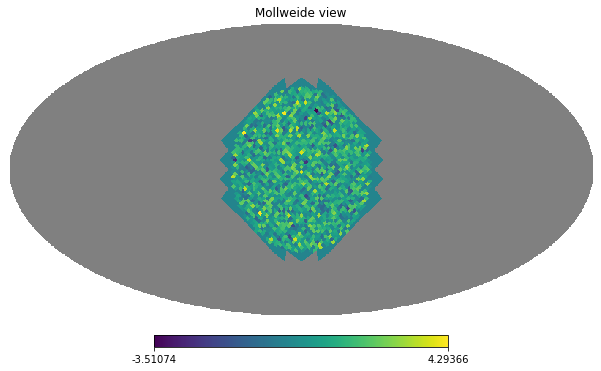

In [34]:
import tensorflow as tf
import numpy as np
import healpy as hp

from DeepSphere.utils import extend_indices
from DeepSphere import healpy_networks as hp_nn
from DeepSphere import gnn_layers
import matplotlib.pyplot as plt

%matplotlib inline

NSIDE = 32
NPIX = hp.nside2npix(NSIDE)

all_ipix = list(range(NPIX))
hp_map = np.zeros(NPIX)

# create a mask
pix = hp.query_disc(nside=NSIDE, vec=np.array([1.0, 0.0, 0.0]), radius=0.75)
hp_map[pix] = 1.0

hp_map_nest = hp.reorder(hp_map, r2n=True)
indices = np.arange(NPIX)[hp_map_nest > 0.5]

# With this first mask we might not be able to properly downsample to a wanted NSIDE
# so we extent the indices
indices_ext = extend_indices(indices=indices, nside_in=NSIDE, nside_out=8)

new_map = np.full(shape=(NPIX), fill_value=hp.UNSEEN)

for indice in indices_ext:
    new_map[indice] = 0.0
for indice in indices:
    new_map[indice] = np.random.normal(1)

hp.mollview(new_map, nest=True)

new_map = np.expand_dims(new_map, axis=0)
new_map = np.expand_dims(new_map, axis=-1)

# Now we'll try to implement custom training:

In [35]:
layers = [gnn_layers.HealpyPseudoConv(p=1, Fout=4, activation='elu'),
          gnn_layers.HealpyPseudoConv(p=1, Fout=4, activation='relu'),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1)]

# build a model
tf.keras.backend.clear_session()
all_indices = np.arange(NPIX)
model = hp_nn.HealpyGCNN(nside=NSIDE, indices=indices_ext, layers=layers)

model.build(input_shape=(1, len(indices_ext), 1))

Detected a reduction factor of 4, the input with nside 32 will be reduced to 8 during a forward pass. Checking for consistency with indices...
indices seem consistent...


In [36]:
# Define the loss and gradient function

# Again we will use the MeanAbsoluteError()
loss_object = tf.keras.losses.MeanAbsoluteError()


def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)
    
    return loss_object(y_true=y, y_pred=y_)

In [37]:
# Use the tf.GradientTape contex to calculate the gradients used
# to optimize the model.
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Setup the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.008)

In [38]:
# Build a training loop
# We want to generate the data on the fly.

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []
global_norm_results = []

num_epochs = 120

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    epoch_global_norm = []
    
    # Training loop - use batches of 500
    # Generate the data on the fly
    for i in range(32):
        mean = np.random.rand()
        training_label = mean
        training_map = np.random.normal(loc=mean, size=len(indices_ext))
        # Add padding
        for index in range(len(indices_ext)):
            if not indices_ext[index] in indices:
                training_map[index] = 0.0

        training_map = np.expand_dims(training_map, axis=0)
        training_map = np.expand_dims(training_map, axis=-1)

        
        # Optimize the model
        loss_value, grads = grad(model, training_map, training_label)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Track progress
        epoch_loss_avg.update_state(loss_value) # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_accuracy.update_state(training_label, model(training_map, training=True))
        epoch_global_norm.append(tf.linalg.global_norm(grads))
        
    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    global_norm_results.append((sum(epoch_global_norm)/len(epoch_global_norm)))

        
    if epoch % 4 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 0.650
Epoch 004: Loss: 0.186
Epoch 008: Loss: 0.119
Epoch 012: Loss: 0.164
Epoch 016: Loss: 0.115
Epoch 020: Loss: 0.169
Epoch 024: Loss: 0.135
Epoch 028: Loss: 0.144
Epoch 032: Loss: 0.109
Epoch 036: Loss: 0.155
Epoch 040: Loss: 0.122
Epoch 044: Loss: 0.155
Epoch 048: Loss: 0.107
Epoch 052: Loss: 0.116
Epoch 056: Loss: 0.132
Epoch 060: Loss: 0.128
Epoch 064: Loss: 0.079
Epoch 068: Loss: 0.160
Epoch 072: Loss: 0.137
Epoch 076: Loss: 0.099
Epoch 080: Loss: 0.120
Epoch 084: Loss: 0.086
Ep

In [39]:
for i in range(10):
    mean = np.random.rand()
    label = mean
    data = np.random.normal(loc=1, size=len(indices_ext))
    # Add padding
    for index in range(len(indices_ext)):
        if not indices_ext[index] in indices:
            data[index] = 0.0
    data = np.expand_dims(data, axis=0)
    data = np.expand_dims(data, axis=-1)
    predictions = model(data)
    print("Model predicted %f, true label is %s" % (predictions, mean))

Model predicted 0.883489, true label is 0.7984568037152232
Model predicted 0.828760, true label is 0.867047085577718
Model predicted 1.033691, true label is 0.26897854652278363
Model predicted 0.917400, true label is 0.4254997359812356
Model predicted 0.864042, true label is 0.4286672419464872
Model predicted 0.861607, true label is 0.35823357061460004
Model predicted 0.974263, true label is 0.045797943444126354
Model predicted 0.928326, true label is 0.06992603430383137
Model predicted 1.054744, true label is 0.25954245897717876
Model predicted 0.890650, true label is 0.8363250606343117


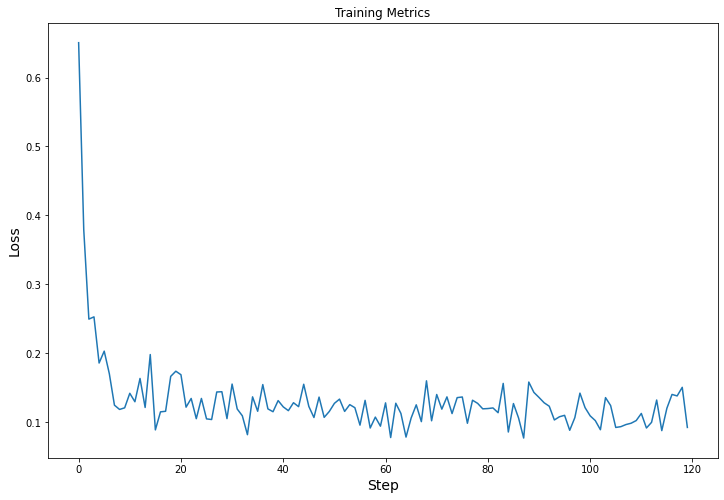

In [40]:
plt.figure(figsize=(12, 8))
plt.title('Training Metrics')

plt.ylabel("Loss", fontsize=14)
plt.plot(train_loss_results)
plt.xlabel("Step", fontsize=14)
plt.show()


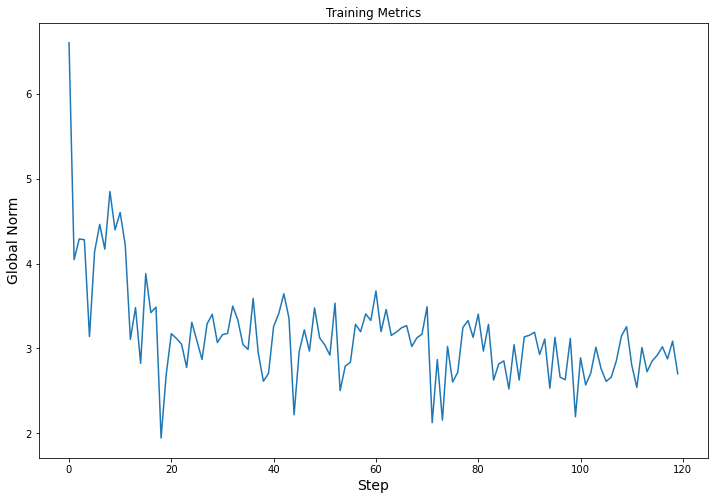

In [41]:
plt.figure(figsize=(12, 8))
plt.title('Training Metrics')

plt.ylabel("Global Norm", fontsize=14)
plt.plot(global_norm_results)
plt.xlabel("Step", fontsize=14)
plt.show()
